In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/edge-image/index.png
/kaggle/input/nature-image/1.jpeg


# Threshold Image Segmentation

In [3]:
from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

In [4]:
image = plt.imread('/kaggle/input/nature-image/1.jpeg')
image.shape


(192, 263, 3)

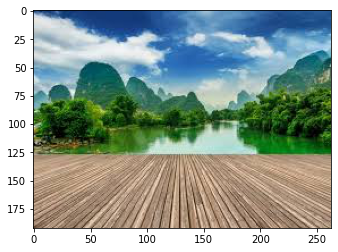

In [5]:
plt.imshow(image)

It is a three-channel image (RGB). We need to convert it into grayscale so that we only have a single channel. Doing this will also help us get a better understanding of how the algorithm works.

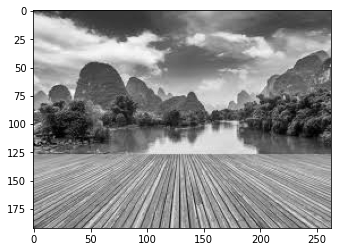

In [6]:
gray = rgb2gray(image)
plt.imshow(gray, cmap='gray')

Now, we want to apply a certain threshold to this image. This threshold should separate the image into two parts – the foreground and the background. Before we do that, let’s quickly check the shape of this image:

In [7]:
gray.shape

(192, 263)

The height and width of the image is 192 and 263 respectively. We will take the mean of the pixel values and use that as a threshold. If the pixel value is more than our threshold, we can say that it belongs to an object. If the pixel value is less than the threshold, it will be treated as the background. Let’s code this:

**Global Threshold**

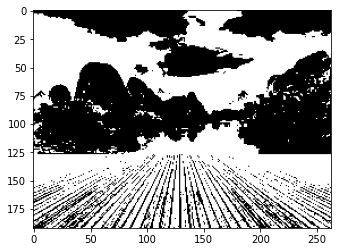

In [8]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])

for i in range (gray_r.shape[0]):
    if gray_r[i]>gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
        
gray_r = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray_r,cmap='gray')

**Local Threshold**

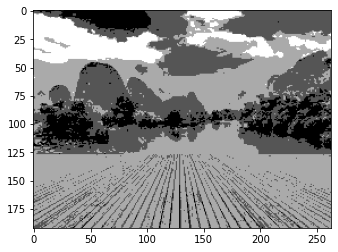

In [9]:
gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

There are four different segments in the above image. You can set different threshold values and check how the segments are made. Some of the advantages of this method are:

Calculations are simpler
Fast operation speed
When the object and background have high contrast, this method performs really well
But there are some limitations to this approach. When we don’t have significant grayscale difference, or there is an overlap of the grayscale pixel values, it becomes very difficult to get accurate segments.

# Edge Detection Segmentation

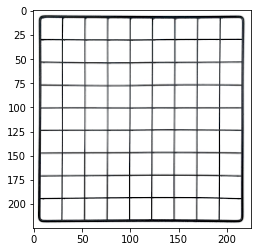

In [10]:
image = plt.imread('/kaggle/input/edge-image/index.png')
plt.imshow(image)

In [11]:
# converting to grayscale
gray = rgb2gray(image)

# defining the sobel filters
sobel_horizontal = np.array([np.array([1, 2, 1]), np.array([0, 0, 0]), np.array([-1, -2, -1])])
print(sobel_horizontal, 'is a kernel for detecting horizontal edges')
 
sobel_vertical = np.array([np.array([-1, 0, 1]), np.array([-2, 0, 2]), np.array([-1, 0, 1])])
print(sobel_vertical, 'is a kernel for detecting vertical edges')

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-2  0  2]
 [-1  0  1]] is a kernel for detecting vertical edges


In [12]:
out_h = ndimage.convolve(gray, sobel_horizontal, mode='reflect')
out_v = ndimage.convolve(gray, sobel_vertical, mode='reflect')
# here mode determines how the input array is extended when the filter overlaps a border.

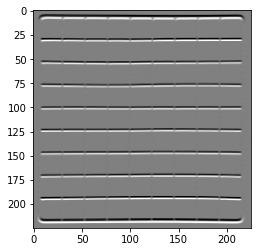

In [14]:
plt.imshow(out_h, cmap='gray')

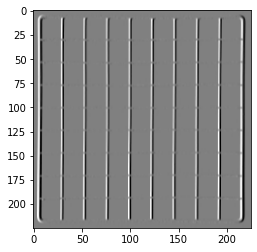

In [15]:
plt.imshow(out_v,cmap='gray')

Here, we are able to identify the horizontal as well as the vertical edges. There is one more type of filter that can detect both horizontal and vertical edges at the same time. This is called the laplace operator:

In [16]:
kernel_laplace = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])
print(kernel_laplace, 'is a laplacian kernel')

[[ 1  1  1]
 [ 1 -8  1]
 [ 1  1  1]] is a laplacian kernel


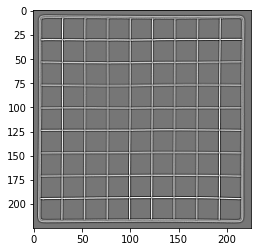

In [17]:
out_l = ndimage.convolve(gray, kernel_laplace, mode='reflect')
plt.imshow(out_l, cmap='gray')

Here, we can see that our method has detected both horizontal as well as vertical edges.

# Clustering Technique

(192, 263, 3)


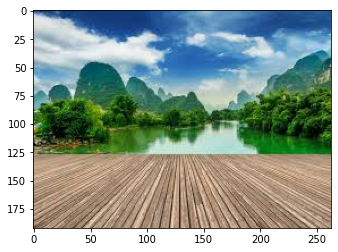

In [18]:
pic = plt.imread('/kaggle/input/nature-image/1.jpeg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)

It’s a 3-dimensional image of shape (192, 263, 3). For clustering the image using k-means, we first need to convert it into a 2-dimensional array whose shape will be (length*width, channels). In our example, this will be (192*263, 3).

In [19]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(50496, 3)

We can see that the image has been converted to a 2-dimensional array. Next, fit the k-means algorithm on this reshaped array and obtain the clusters. The cluster_centers_ function of k-means will return the cluster centers and labels_ function will give us the label for each pixel (it will tell us which pixel of the image belongs to which cluster).

In [20]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

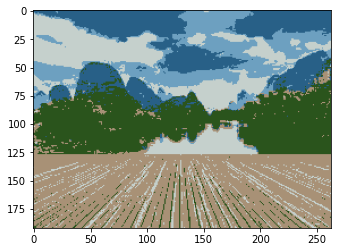

In [21]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

k-means works really well when we have a small dataset. It can segment the objects in the image and give impressive results. But the algorithm hits a roadblock when applied on a large dataset (more number of images).

It looks at all the samples at every iteration, so the time taken is too high. Hence, it’s also too expensive to implement. And since k-means is a distance-based algorithm, it is only applicable to convex datasets and is not suitable for clustering non-convex clusters.